In [1]:
from IPython.display import HTML, SVG, IFrame

In [2]:
import math

# Neural Nets SVG dims, this is for the NN forward-pass walkthrough.
# SVG's default size is 732x518 ~ which is the (width * 0.7076502732)
NN_SVG_W = 732
NN_SVG_H = math.ceil(NN_SVG_W * 0.7076502732) + 20

# Building an Extensible Neural Network
---

## Featuring, [TensorFlow](https://tensorflow.org/)

We'll be classifying the MNIST dataset.

MNIST is ~70,000 images of handwritten digits &ndash; bear in mind, this is essentially a solved problem, so we're not doing anything novel.

---

**What you should leave with:** You should leave here with a practical understanding of how to implement an Extensible Artificial Neural Network (ANN) in TensorFlow, from scratch. The concepts don't change when you move to different domains, simply the way in which you apply them. You understanding of the _central_ concept of ANNs, **backpropagation (backprop)** should be well-founded and given some more practice, you ought to be able to explain this to a friend.

You should also leave here with an itch to scratch about TensorFlow, and how using such a library can speed up your model development, as well as understanding some of it's drawbacks.

### Contents:

1. [The Math Behind Backprop](#1.-The-Math-Behind-Backprop)
2. [Some Prep-processing](#2.-Some-Pre-processing-(&-Setup))
3. [Building an ANN from "Scratch"](#3.-Building-an-ANN-from-"Scratch")
4. [Peeking Inside the Network](#4.-Peeking-Inside-the-Network)
5. [Exploring TensorBoard](#5.-Exploring-the-TensorBoard)

---

# 1. The Math Behind Backprop

In the [Math Primer](https://github.com/ucfsigai/meetings/sp18/math-primer1.ipynb), we talked about derivatives, partials, vectors, dot and cross products, and matrices.

There's one thing we're missing before we can actually build a Neural Network though.

Let's think back to the Neural Network lecture.

In [3]:
IFrame("assets/nns/fwd.html", width=NN_SVG_W, height=NN_SVG_H)

So, let's introduce some notation:

Let's subscript the `x` layer (`x1`, `x2`, `x3`) and let's do the same for the hidden layers (`h11`, `h12`, ..., `h23`, `h24`).

Now let's try calculating the inputs to `h11`. It would be...
$h_{11} = x_1 \cdot w_{11} + x_2 \cdot w_{21} + x_3 \cdot w_{31}$, right?

That works, but now let's do the inputs to `h12`...
$h_{12} = x_1 \cdot w_{12} + x_2 \cdot w_{22} + x_3 \cdot w_{32}$.

And for `h13`...

$h_{13} = x_1 \cdot w_{13} + x_2 \cdot w_{23} + x_3 \cdot w_{33}$.

Finally, for `h14`...

$h_{14} = x_1 \cdot w_{14} + x_2 \cdot w_{24} + x_3 \cdot w_{34}$, right?

Does anyone see a pattern?

Let's drag this out, so it's aligned a little more nicely:

$h_{11} = x_1 \cdot w_{11} + x_2 \cdot w_{21} + x_3 \cdot w_{31}$

$h_{12} = x_1 \cdot w_{12} + x_2 \cdot w_{22} + x_3 \cdot w_{32}$

$h_{13} = x_1 \cdot w_{13} + x_2 \cdot w_{23} + x_3 \cdot w_{33}$

$h_{14} = x_1 \cdot w_{14} + x_2 \cdot w_{24} + x_3 \cdot w_{34}$

Does this look like a certain math operation we learned 2 weeks ago?

**Yes! It looks an awful lot like a dot product.**

So, let's try to represent this like a dot product.

In [4]:
%%latex
% x_{11}
\begin{bmatrix}
\end{bmatrix}

<IPython.core.display.Latex object>

So, an observation that may not be immediately obvious is that we can represent sets of vectors as a matrix. This isn't terribly important for **_us_**, because calculating a dot-product on between a $4 \times 3$ Matrix and a $3$-row Vector is time consuming, especially if we have to do it 100K times.

But, there's a computational reason for this, and I won't cover it now &ndash; but doing a dot product saves us countless for loops and doesn't affect our application of activation functions and backprop! :D

---

# 2. Some Pre-processing (&amp; Setup)

In [5]:
## imports
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

## globals
LOG_DIR = "/tmp/mnist/"
DAT_DIR = "/tmp/mnist/data/"

## learning rate
LRN_RAT = 0.5

## loading MNIST and setting up looping meta
mnist = input_data.read_data_sets(DAT_DIR, one_hot=True)
_epochs = 6
BATCHES = 100
NXAMPLS = (_epochs * mnist.train.num_examples) // BATCHES

## making sure the LOG_DIR is empty - we'll need this for TensorBoard
if tf.gfile.Exists(LOG_DIR):
    tf.gfile.DeleteRecursively(LOG_DIR)
tf.gfile.MakeDirs(LOG_DIR)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/mnist/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/mnist/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/mnist/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/mnist/data/t10k-labels-idx1-ubyte.gz


---

# 3. Building an ANN from "Scratch"

We say "Scratch" because TensorFlow actually does quite a bit of head lifting for us. We'll still walk through how you might code this up in raw [Python](https://python.org/), [NumPy](http://numpy.org), and [SciPy](http://scipy.org), at the end.

Something worth noting is that building the ANN yourself, **_can_** run faster than the ANN we'll be building with TensorFlow; but libraries like [TensorFlow](https://tensorflow.org), [PyTorch](http://pytorch.org), [Keras](https://keras.io), and the like speed up your construction of the model.

---

### On to the workshop.

Last semeseter, we built a class &ndash; tonight, we won't. This is largely to do with the way in which TensorFlow works. The `scope`-ing we'll be doing tonight will be similar to the encapsulation classes allow for. We'll take a look at the TensorBoard on occasion; so before we move on...

**Let's open up a terminal window from Jupyter**
1. Open `localhost:19972`
2. Click on "New" and pick "Terminal"
3. `tensorboard --logdir=/tmp/mnist`
---

**Now, let's dive into some code.**

First, we need to create a TensorFlow `InteractiveSession`. This will let our code seem a little more normal.

TensorFlow is quirky in the way you write code, but a lot of this will make sense once we get through to the end. Bear with me. :)

In [6]:
sess = tf.InteractiveSession()

### Let's Setup the IO.

So... what do we want our network to do?

1. We want to take in 28x28 pixel images
2. We want to classify them into digits from 0..9

It's worth noting that $28^2 = 784$.

In [7]:
INP_DIM = 784
OUT_DIM = 10

with tf.name_scope("input"):
    x  = tf.placeholder(tf.float32, [None, INP_DIM], name="x-input")
    y_ = tf.placeholder(tf.float32, [None, OUT_DIM], name="y-input")

Hold-up! What are `tf.name_scope`s? Good question. Depending on your programming style, you may use your functions to segment portions of your program/classes into "logical" groupings. `tf.name_scope`s are how we do this with TensorFlow. Now, we could just do standard programming, but `tf.name_scope`s allow us to use the TensorBoard to visualize what's going on, and better understand the structure of our Neural Network.

---

Also... what's a `tf.placeholder`? Again, good question. `tf.placeholders` are basically promises to TensorFlow that you'll supply the information to fill these variables. You'll see, later, that we use a rather specific way to feed `tf.placeholder`s data.

---

### Posting Image Previews to TensorBoard

We'll be looking at this in the TensorBoard &ndash; we can use the "Images" tab to preview what our images in the training and testing sets look like for a given class.

In [8]:
with tf.name_scope("input_reshape"):
    img_shape_inp = tf.reshape(x, [-1, 28, 28, 1])
    tf.summary.image("input", img_shape_inp, 10)

---

### Building Some Helper Functions

To make our code a little more descriptive and somewhat portable, let's export `Bias` and `Weight` creation to functions that we can call by specifying the shape instead of having to hand-write these, every, single, time. (Commas for emphasis.)

In [9]:
def var_biases(shape):
    init = tf.constant(0.1, shape=shape)
    return tf.Variable(init)

In [10]:
def var_weight(shape):
    init = tf.truncated_normal(shape, stddev=pow(shape[0], -0.5))
    return tf.Variable(init)

This is a helper function for us to be able to export certain charts and histograms to the TensorBoard. If you'd like, I can elaborate on what's happening here in more detail &ndash; if so, I'll do my best to update these notes.

In [11]:
def var_summarize(var):
    with tf.name_scope("summaries"):
        
        mean = tf.reduce_mean(var)
        tf.summary.scalar("mean", mean)
        
        with tf.name_scope("stddev"):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar("stddev", stddev)
        
        tf.summary.scalar("max", tf.reduce_max(var))
        tf.summary.scalar("min", tf.reduce_min(var))
        
        tf.summary.histogram("histogram", var)    

Why write lines upon lines of code, when you can write a function?! :D

This function builds each one of our layers, with consistent `tf.name_scope`s and attaches the necessary TensorBoard utilities for us to use.

In [12]:
def Layer(name, inp_ten, inp_dim, out_dim, act=tf.nn.sigmoid):
    with tf.name_scope(name):
        
        with tf.name_scope("weights"):
            weights = var_weight([inp_dim, out_dim])
            var_summarize(weights)
            
#         with tf.name_scope("biases"):
#             biases  = var_biases([out_dim])
#             var_summarize(biases)
            
        with tf.name_scope("Wx_plus_b"):
            pre_activation = tf.matmul(inp_ten, weights)# + biases
            tf.summary.histogram("pre_activation", pre_activation)
            
        activation = act(pre_activation, name="activation")
        tf.summary.histogram("activations", activation)
        
        return activation

---

### Network Overhead's Done, Let's Build it Out

- `nodes` is how we'll specify the number of nodes in a given layer.
- `layers` is a list that stores references to all the inputs of the network.

We'll also derive some other information to assign the layer while iterating.

In [13]:
SEED = 42

def arch_check(nodes):
    return len(nodes) >= 2

nodes = [INP_DIM, 200, 200, 200, OUT_DIM]

tf.set_random_seed(SEED)

layers = [x]

if arch_check(nodes):
    for idx in range(len(nodes) - 2):
        name = "hidden_{}".format(idx)
        prev = layers[idx]
        inp_dim = nodes[idx]
        out_dim = nodes[idx + 1]
        new_lyr = Layer(name, prev, inp_dim, out_dim)
        layers.append(new_lyr)

    y = Layer("output", layers[-1], nodes[-2], nodes[-1], act=tf.identity)

#### Building the Cost Function

Like we talked about, briefly, in the last lecture... we need a cost function &ndash; otherwise our network can't converge. 

We'll be using cross-entropy loss (or log loss). It's defined at: $H_{y'}(y) = -\Sigma_i y'_i log(y_i)$. $y$ is our predicted probabilities and $y'$ is the true probabilities. You can imagine this as cross-entropy measuring how inefficient our predictions are at describing the truth. [If you want to learn more.](https://colah.github.io/posts/2015-09-Visual-Information)

In [14]:
with tf.name_scope("cross_entropy"):
    diff = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)
    
    with tf.name_scope("total"):
        xentropy = tf.reduce_mean(diff)
        
tf.summary.scalar("xentropy", xentropy)

<tf.Tensor 'xentropy:0' shape=() dtype=string>

Because of the structure of TensorFlow, we'll be using the build-in gradient descent optimizer. (If you want to look at more of TensorFlow's Optimizers, you'll find them [here](https://github.com/tensorflow/tensorflow/blob/r1.4/tensorflow/python/training/).)

We should recall that **Gradient Descent** is strictly an optimization algorithm; recently it's become less popular in favor of newer algorithms like [Adam](https://arxiv.org/abs/1412.6980) and [RMSprop](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf#page=26) which offer some advantages over Gradient Descent.

Let's review how Gradient Descent works, though; before moving past this section.

In [15]:
with tf.name_scope("train"):
    train_step = tf.train.GradientDescentOptimizer(LRN_RAT).minimize(xentropy)

Now, we need to tell TensorFlow how we want to validate our predictions and calculate the accuracy.

In [16]:
with tf.name_scope("accuracy"):
    with tf.name_scope("correct_prediction"):
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    with tf.name_scope("accuracy"):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
tf.summary.scalar("accuracy", accuracy)

<tf.Tensor 'accuracy_1:0' shape=() dtype=string>

### Some TensorBoard Overhead

This is simply code to export our logs for the TensorBoard to read them.

In [17]:
merged = tf.summary.merge_all()
trn_writer = tf.summary.FileWriter(LOG_DIR + "train/", sess.graph)
tst_writer = tf.summary.FileWriter(LOG_DIR + "test/")

---

### On the Home Stretch to Training

All that `feed_dict()` does for us is construct our mini-batches to make the looping a tad prettier.

This is how we'll feed those `tf.placeholder`s we wrote up ages ago. TensorFlow uses the `feed_dict` parameter in `sess.run()` to assign values to `tf.placeholder`s in the model.

In [18]:
def feed_dict(train):
    xs, ys = mnist.train.next_batch(BATCHES) if train else (mnist.test.images, mnist.test.labels)
    
    return {x: xs, y_: ys}

### Training the Network on MNIST

Now, let's move on to training the network! We've already specified our parameters, now we just need to tell TensorFlow to do its thing. :D

**Tangent:** `tf.global_variables_initializer().run()` is how the TensorFlow Graph actually starts up. Up until now we're really just been writing mark-up. `tf...run()` allows us to actually act on the Compute Graph.

In [19]:
tf.global_variables_initializer().run()

for step in range(NXAMPLS):
    if step % 10 == 0:
        summary, acc = sess.run([merged, accuracy], feed_dict=feed_dict(False))
        tst_writer.add_summary(summary, step)
    else:
        if step % 100 == 99:
            run_opts = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
            run_meta = tf.RunMetadata()
            summary, _ = sess.run([merged, train_step], feed_dict=feed_dict(True), 
                                  options=run_opts, run_metadata=run_meta)
            trn_writer.add_run_metadata(run_meta, "step{:03d}".format(step))
            trn_writer.add_summary(summary, step)
        else:
            summary, _ = sess.run([merged, train_step], feed_dict=feed_dict(True))
            trn_writer.add_summary(summary, step)
        
trn_writer.close()
tst_writer.close()

---

# 4. Exploring the TensorBoard

To watch our network training through TensorBoard, let's open up `localhost:19973`.

---

# 5. Peeking Inside the Network

To peek inside the network, we can't use TensorFlow &ndash; so it looks like we'll be rolling our own Neural Network. This one will take a little bit longer to train because it doesn't have as much optimization as the TensorFlow library does. Bear with me.

Just a heads-up, I'm no Houdini, so... here's where we got the idea for [Backquery](https://github.com/makeyourownneuralnetwork/makeyourownneuralnetwork/blob/master/part3_neural_network_mnist_backquery.ipynb).

In [20]:
import numpy as np
import scipy as sp
from scipy.special import expit, logit

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [29]:
class NeuralNetwork:
    
    def __init__(self, nodes, learn_rate):
        self.nodes = nodes
        self.learn_rate = learn_rate
        
        self.act_nrm = lambda x: expit(x)
        self.act_inv = lambda x: logit(x)
        self.act_dx_ = lambda x: (x * (1 - x))
        
        self.weights = [np.random.normal(0., pow(node, -.5), (nodes[idx + 1], node)) 
                        for idx, node in enumerate(self.nodes[:-1])]
        
    def train(self, inpt, targ):
        inpts = np.array(inpt, ndmin=2).T
        targs = np.array(targ, ndmin=2).T
        
        layers = [inpts,]
        for idx, weight in enumerate(self.weights):
            inp = np.matmul(weight, layers[idx])
            out = self.act_nrm(inp)
            layers.append(out)

        errors = [targs - layers[-1],]
        for idx, weight in enumerate(self.weights[1:][::-1]):
            rev = np.matmul(weight.T, errors[idx])
            errors.append(rev)   
        
        errors = errors[::-1]
            
        for idx, (err, lyr) in enumerate(zip(errors, layers[:-1])):
            upd = err * self.act_dx_(layers[idx + 1])
            self.weights[idx] += self.learn_rate * np.matmul(upd, lyr.T)
        
    def query(self, inpt):
        inpts = np.array(inpt, ndmin=2).T
        
        layers = [inpts,]
        for idx, weight in enumerate(self.weights):
            inp = np.matmul(weight, layers[idx])
            out = self.act_nrm(inp)
            layers.append(out)
            
        return layers[-1]
    
    def backquery(self, targ):
        targs = np.array(targ, ndmin=2).T
        
        rev = self.act_inv(targs)
        out = np.matmul(self.weights[-1].T, rev)
        query = [out,]
        for idx, weight in enumerate(self.weights[:-1][::-1]):
            rev = self.act_inv(query[idx])
            out = np.matmul(weight.T, rev)
            out -= np.min(out)
            out /= np.max(out)
            out *= 0.98
            out += 0.01
            query.append(out)
        
        return query[-1].reshape(28, 28)

In [34]:
nn = NeuralNetwork(nodes, LRN_RAT)

In [35]:
for e in range(_epochs * mnist.train.num_examples):
    inpt, labl = mnist.train.next_batch(1)
    labl[labl != 1.] = 0.01
    labl[labl == 1.] = 0.99
    labl = labl[0]
    nn.train(inpt, labl)

In [38]:
score = np.zeros(mnist.test.num_examples)
for r in range(mnist.test.num_examples):
    inpt, labl = mnist.test.next_batch(1)
    labl[labl != 1.] = 0.01
    labl[labl == 1.] = 0.99
    labl = labl[0]
    print(labl)
    
    pred = nn.query(inpt)
    
    score[r] = int(np.argmax(pred) == np.argmax(labl))
    
print("performance: {:0.4f}".format(score.sum() / score.shape[0]))

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
[ 0.01  

Querying for 0: [ 0.99  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
Querying for 1: [ 0.01  0.99  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
Querying for 2: [ 0.01  0.01  0.99  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
Querying for 3: [ 0.01  0.01  0.01  0.99  0.01  0.01  0.01  0.01  0.01  0.01]
Querying for 4: [ 0.01  0.01  0.01  0.01  0.99  0.01  0.01  0.01  0.01  0.01]
Querying for 5: [ 0.01  0.01  0.01  0.01  0.01  0.99  0.01  0.01  0.01  0.01]
Querying for 6: [ 0.01  0.01  0.01  0.01  0.01  0.01  0.99  0.01  0.01  0.01]
Querying for 7: [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.99  0.01  0.01]
Querying for 8: [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.99  0.01]
Querying for 9: [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.99]


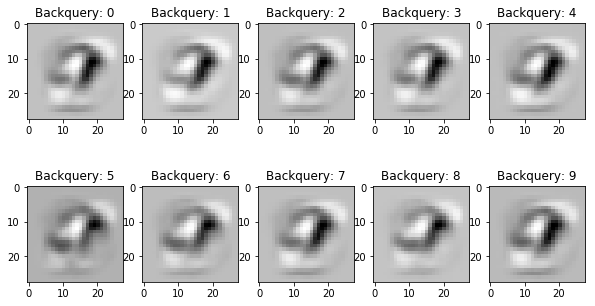

In [27]:
inpt = np.array([0.01 for _ in range(10)])
back = []

fig = plt.figure(figsize=(10, 8))
ax = []
cols = 5
grid = gridspec.GridSpec(10 // cols + 1, cols)
grid.update(hspace=0.5)

for _ in range(10):
    query = np.copy(inpt)
    query[_] = 0.99
    print("Querying for {}: {}".format(_, query))
    back.append(nn.backquery(query))

    row = (_ // cols)
    col = (_ %  cols)
    ax.append(fig.add_subplot(grid[row, col]))
    ax[-1].set_title("Backquery: {}".format(_))
    ax[-1].imshow(back[-1], cmap="Greys", interpolation="none")
#     display(back[-1])
#     plt.imshow(back[-1], cmap="Greys", interpolation="none")

# And... we're done! You've just coded up a Neural Network in TensorFlow, taking a walk through TensorBoard, and also peeked inside a Neural Network.